# Train Detectron2 with Custom COCO Datasets

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import gdown
import torch

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Register your own data set in coco format

In [2]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances('wamv_train', {}, 
                        '/home/arg/Mask-RCNN-Detectron2/datasets/wamv_boats_split/train.json', 
                       '/home/arg/Mask-RCNN-Detectron2/datasets/wamv_boats_split/train')
register_coco_instances('wamv_val', {}, 
                        '/home/arg/Mask-RCNN-Detectron2/datasets/wamv_boats_split/val.json', 
                       '/home/arg/Mask-RCNN-Detectron2/datasets/wamv_boats_split/val')

In [3]:
subt_metadata = MetadataCatalog.get("wamv_val")
dataset_dicts = DatasetCatalog.get("wamv_val")
subt_metadata


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Metadata(evaluator_type='coco', image_root='/home/arg/Mask-RCNN-Detectron2/datasets/wamv_boats_split/val', json_file='/home/arg/Mask-RCNN-Detectron2/datasets/wamv_boats_split/val.json', name='wamv_val', thing_classes=['_background_', 'WAM_V', 'Boat'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2})

## Visualize dataset - make sure the data is loaded without problems

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the dataset.

{'file_name': '/home/arg/Mask-RCNN-Detectron2/datasets/wamv_boats_split/val/Scene10_131.jpg', 'height': 480, 'width': 640, 'image_id': 175, 'annotations': [{'iscrowd': 0, 'bbox': [292.4081726074219, 227.93603515625, 68.96310424804688, 39.956298828125], 'category_id': 2, 'segmentation': [[345, 233, 344, 234, 341, 234, 340, 235, 336, 235, 335, 236, 332, 236, 331, 237, 329, 237, 328, 238, 327, 238, 326, 237, 325, 237, 324, 238, 322, 238, 321, 239, 319, 239, 317, 241, 316, 240, 316, 241, 315, 242, 314, 242, 313, 241, 312, 241, 312, 242, 311, 243, 310, 242, 309, 242, 308, 243, 306, 243, 306, 244, 305, 245, 304, 245, 303, 244, 303, 245, 302, 246, 301, 246, 300, 245, 300, 246, 294, 252, 305, 252, 306, 251, 308, 251, 312, 255, 305, 262, 306, 262, 307, 263, 314, 263, 315, 262, 317, 262, 318, 261, 320, 261, 321, 260, 323, 260, 324, 259, 326, 259, 327, 258, 329, 258, 330, 257, 332, 257, 333, 256, 335, 256, 336, 255, 338, 255, 339, 254, 340, 254, 341, 253, 343, 253, 344, 252, 346, 252, 349, 249, 3

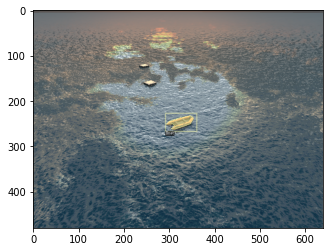

In [7]:
import random

for d in random.sample(dataset_dicts, 1):
    print(d)
    img = cv2.imread(d["file_name"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    visualizer = Visualizer(img[:, :, ::-1], metadata=subt_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1], cmap='nipy_spectral')
    #cv2.waitKey(0)

## Change configuration parameters
Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the dataset.

In [8]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("wamv_train",)
cfg.DATASETS.TEST = ("wamv_val", )
cfg.DATALOADER.NUM_WORKERS = 0 #Single thread
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # datasets classes
cfg.SOLVER.IMS_PER_BATCH = 4 #Batch size
ITERS_IN_ONE_EPOCH = 610 #dataset_imgs/batch_size  
cfg.SOLVER.MAX_ITER = (ITERS_IN_ONE_EPOCH * 50) # ITERS

cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.GAMMA = 0.1
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 1000
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.WARMUP_METHOD = "linear"
cfg.SOLVER.CHECKPOINT_PERIOD = ITERS_IN_ONE_EPOCH #Save training model interval


In [9]:
print(cfg.OUTPUT_DIR)
!ls

./output
Output			      split
README.md		      train-MaskRCNN-SubT.ipynb
analyze_model.py	      train-MaskRCNN-Wamv.ipynb
benchmark.py		      train_net.py
convert-torchvision-to-d2.py  unity_wamv_detect.py
deploy			      visualize_data.py
evaluate-MaskRCNN-SubT.ipynb  visualize_json_results.py
plain_train_net.py


## Training


In [10]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(False)
trainer.train()

[03/27 18:27:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

WARNING [03/27 18:27:07 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/27 18:27:07 d2.data.datasets.coco]: Loaded 1600 images in COCO format from /home/arg/Mask-RCNN-Detectron2/datasets/wamv_boats_split/train.json
[03/27 18:27:07 d2.data.build]: Removed 0 images with no usable annotations. 1600 images left.
[03/27 18:27:07 d2.data.build]: Distribution of instances among all 3 categories:
|   category   | #instances   |  category  | #instances   |  category  | #instances   |
|:------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| _background_ | 0            |   WAM_V    | 813          |    Boat    | 787          |
|              |              |            |              |            |              |
|    total     | 1600         |            |              |            |              |
[03/27 18:27:07 d2.data.common]: Serializing 1600 elements to byte tensors and concatenating them 

model_final_f10217.pkl: 178MB [00:02, 71.9MB/s]                            
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due t

[03/27 18:27:09 d2.engine.train_loop]: Starting training from iteration 0
[03/27 18:27:23 d2.utils.events]:  eta: 5:24:25  iter: 19  total_loss: 3.161  loss_cls: 1.870  loss_box_reg: 0.592  loss_mask: 0.691  loss_rpn_cls: 0.011  loss_rpn_loc: 0.006  time: 0.6706  data_time: 0.0751  lr: 0.000005  max_mem: 4145M
[03/27 18:27:36 d2.utils.events]:  eta: 5:41:04  iter: 39  total_loss: 3.013  loss_cls: 1.728  loss_box_reg: 0.586  loss_mask: 0.684  loss_rpn_cls: 0.013  loss_rpn_loc: 0.005  time: 0.6689  data_time: 0.0714  lr: 0.000010  max_mem: 4145M
[03/27 18:27:50 d2.utils.events]:  eta: 5:46:30  iter: 59  total_loss: 2.669  loss_cls: 1.423  loss_box_reg: 0.535  loss_mask: 0.668  loss_rpn_cls: 0.011  loss_rpn_loc: 0.006  time: 0.6751  data_time: 0.0719  lr: 0.000015  max_mem: 4145M
[03/27 18:28:04 d2.utils.events]:  eta: 5:48:16  iter: 79  total_loss: 2.296  loss_cls: 1.064  loss_box_reg: 0.560  loss_mask: 0.651  loss_rpn_cls: 0.012  loss_rpn_loc: 0.005  time: 0.6785  data_time: 0.0711  lr:

[03/27 18:34:57 d2.utils.events]:  eta: 5:46:31  iter: 679  total_loss: 0.382  loss_cls: 0.046  loss_box_reg: 0.182  loss_mask: 0.173  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.6845  data_time: 0.0711  lr: 0.000170  max_mem: 4145M
[03/27 18:35:11 d2.utils.events]:  eta: 5:46:21  iter: 699  total_loss: 0.382  loss_cls: 0.042  loss_box_reg: 0.159  loss_mask: 0.163  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.6845  data_time: 0.0706  lr: 0.000175  max_mem: 4145M
[03/27 18:35:25 d2.utils.events]:  eta: 5:46:21  iter: 719  total_loss: 0.424  loss_cls: 0.044  loss_box_reg: 0.166  loss_mask: 0.190  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  time: 0.6848  data_time: 0.0712  lr: 0.000180  max_mem: 4145M
[03/27 18:35:38 d2.utils.events]:  eta: 5:46:05  iter: 739  total_loss: 0.380  loss_cls: 0.039  loss_box_reg: 0.172  loss_mask: 0.181  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.6848  data_time: 0.0708  lr: 0.000185  max_mem: 4145M
[03/27 18:35:52 d2.utils.events]:  eta: 5:45

[03/27 18:42:37 d2.utils.events]:  eta: 5:42:35  iter: 1339  total_loss: 0.299  loss_cls: 0.029  loss_box_reg: 0.125  loss_mask: 0.159  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.6889  data_time: 0.0709  lr: 0.000250  max_mem: 4145M
[03/27 18:42:51 d2.utils.events]:  eta: 5:42:25  iter: 1359  total_loss: 0.302  loss_cls: 0.024  loss_box_reg: 0.099  loss_mask: 0.165  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6889  data_time: 0.0700  lr: 0.000250  max_mem: 4145M
[03/27 18:43:05 d2.utils.events]:  eta: 5:42:07  iter: 1379  total_loss: 0.316  loss_cls: 0.030  loss_box_reg: 0.120  loss_mask: 0.170  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6889  data_time: 0.0711  lr: 0.000250  max_mem: 4145M
[03/27 18:43:18 d2.utils.events]:  eta: 5:41:36  iter: 1399  total_loss: 0.326  loss_cls: 0.030  loss_box_reg: 0.121  loss_mask: 0.176  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.6888  data_time: 0.0703  lr: 0.000250  max_mem: 4145M
[03/27 18:43:32 d2.utils.events]:  eta: 

[03/27 18:50:19 d2.utils.events]:  eta: 5:36:12  iter: 1999  total_loss: 0.292  loss_cls: 0.025  loss_box_reg: 0.101  loss_mask: 0.162  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.6913  data_time: 0.0709  lr: 0.000250  max_mem: 4145M
[03/27 18:50:33 d2.utils.events]:  eta: 5:35:55  iter: 2019  total_loss: 0.306  loss_cls: 0.021  loss_box_reg: 0.116  loss_mask: 0.166  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.6914  data_time: 0.0704  lr: 0.000250  max_mem: 4145M
[03/27 18:50:46 d2.utils.events]:  eta: 5:35:42  iter: 2039  total_loss: 0.294  loss_cls: 0.026  loss_box_reg: 0.105  loss_mask: 0.158  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.6913  data_time: 0.0709  lr: 0.000250  max_mem: 4145M
[03/27 18:51:00 d2.utils.events]:  eta: 5:35:25  iter: 2059  total_loss: 0.277  loss_cls: 0.024  loss_box_reg: 0.103  loss_mask: 0.147  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6912  data_time: 0.0711  lr: 0.000250  max_mem: 4145M
[03/27 18:51:14 d2.utils.events]:  eta: 

[03/27 18:57:58 d2.utils.events]:  eta: 5:27:56  iter: 2659  total_loss: 0.245  loss_cls: 0.022  loss_box_reg: 0.085  loss_mask: 0.134  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6916  data_time: 0.0714  lr: 0.000250  max_mem: 4145M
[03/27 18:58:12 d2.utils.events]:  eta: 5:27:36  iter: 2679  total_loss: 0.273  loss_cls: 0.020  loss_box_reg: 0.086  loss_mask: 0.157  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6915  data_time: 0.0711  lr: 0.000250  max_mem: 4145M
[03/27 18:58:26 d2.utils.events]:  eta: 5:27:21  iter: 2699  total_loss: 0.266  loss_cls: 0.021  loss_box_reg: 0.092  loss_mask: 0.141  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6915  data_time: 0.0707  lr: 0.000250  max_mem: 4145M
[03/27 18:58:39 d2.utils.events]:  eta: 5:27:07  iter: 2719  total_loss: 0.272  loss_cls: 0.022  loss_box_reg: 0.096  loss_mask: 0.148  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6913  data_time: 0.0707  lr: 0.000250  max_mem: 4145M
[03/27 18:58:53 d2.utils.events]:  eta: 

[03/27 19:05:35 d2.utils.events]:  eta: 5:19:27  iter: 3319  total_loss: 0.227  loss_cls: 0.017  loss_box_reg: 0.081  loss_mask: 0.126  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0708  lr: 0.000250  max_mem: 4145M
[03/27 19:05:49 d2.utils.events]:  eta: 5:19:08  iter: 3339  total_loss: 0.257  loss_cls: 0.018  loss_box_reg: 0.082  loss_mask: 0.154  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0709  lr: 0.000250  max_mem: 4145M
[03/27 19:06:03 d2.utils.events]:  eta: 5:18:54  iter: 3359  total_loss: 0.244  loss_cls: 0.015  loss_box_reg: 0.082  loss_mask: 0.135  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6910  data_time: 0.0704  lr: 0.000250  max_mem: 4145M
[03/27 19:06:17 d2.utils.events]:  eta: 5:18:40  iter: 3379  total_loss: 0.255  loss_cls: 0.020  loss_box_reg: 0.088  loss_mask: 0.135  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0711  lr: 0.000250  max_mem: 4145M
[03/27 19:06:31 d2.utils.events]:  eta: 

[03/27 19:13:16 d2.utils.events]:  eta: 5:12:02  iter: 3979  total_loss: 0.218  loss_cls: 0.016  loss_box_reg: 0.077  loss_mask: 0.114  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6915  data_time: 0.0707  lr: 0.000250  max_mem: 4145M
[03/27 19:13:29 d2.utils.events]:  eta: 5:11:46  iter: 3999  total_loss: 0.252  loss_cls: 0.020  loss_box_reg: 0.078  loss_mask: 0.149  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6914  data_time: 0.0705  lr: 0.000250  max_mem: 4145M
[03/27 19:13:43 d2.utils.events]:  eta: 5:11:26  iter: 4019  total_loss: 0.232  loss_cls: 0.019  loss_box_reg: 0.073  loss_mask: 0.144  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6914  data_time: 0.0713  lr: 0.000250  max_mem: 4145M
[03/27 19:13:56 d2.utils.events]:  eta: 5:11:09  iter: 4039  total_loss: 0.240  loss_cls: 0.019  loss_box_reg: 0.074  loss_mask: 0.135  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0703  lr: 0.000250  max_mem: 4145M
[03/27 19:14:09 d2.utils.events]:  eta: 

[03/27 19:20:54 d2.utils.events]:  eta: 5:04:23  iter: 4639  total_loss: 0.209  loss_cls: 0.015  loss_box_reg: 0.073  loss_mask: 0.122  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6913  data_time: 0.0714  lr: 0.000250  max_mem: 4145M
[03/27 19:21:08 d2.utils.events]:  eta: 5:04:05  iter: 4659  total_loss: 0.229  loss_cls: 0.019  loss_box_reg: 0.085  loss_mask: 0.123  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6914  data_time: 0.0707  lr: 0.000250  max_mem: 4145M
[03/27 19:21:22 d2.utils.events]:  eta: 5:03:52  iter: 4679  total_loss: 0.238  loss_cls: 0.021  loss_box_reg: 0.070  loss_mask: 0.150  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6915  data_time: 0.0711  lr: 0.000250  max_mem: 4145M
[03/27 19:21:36 d2.utils.events]:  eta: 5:03:39  iter: 4699  total_loss: 0.226  loss_cls: 0.017  loss_box_reg: 0.068  loss_mask: 0.132  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6915  data_time: 0.0712  lr: 0.000250  max_mem: 4145M
[03/27 19:21:50 d2.utils.events]:  eta: 

[03/27 19:28:32 d2.utils.events]:  eta: 4:56:40  iter: 5299  total_loss: 0.232  loss_cls: 0.018  loss_box_reg: 0.071  loss_mask: 0.136  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6914  data_time: 0.0704  lr: 0.000250  max_mem: 4145M
[03/27 19:28:47 d2.utils.events]:  eta: 4:56:22  iter: 5319  total_loss: 0.220  loss_cls: 0.022  loss_box_reg: 0.072  loss_mask: 0.127  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6914  data_time: 0.0714  lr: 0.000250  max_mem: 4145M
[03/27 19:29:00 d2.utils.events]:  eta: 4:56:00  iter: 5339  total_loss: 0.232  loss_cls: 0.016  loss_box_reg: 0.064  loss_mask: 0.142  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6914  data_time: 0.0702  lr: 0.000250  max_mem: 4145M
[03/27 19:29:14 d2.utils.events]:  eta: 4:55:50  iter: 5359  total_loss: 0.243  loss_cls: 0.017  loss_box_reg: 0.079  loss_mask: 0.153  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6914  data_time: 0.0703  lr: 0.000250  max_mem: 4145M
[03/27 19:29:28 d2.utils.events]:  eta: 

[03/27 19:36:11 d2.utils.events]:  eta: 4:48:49  iter: 5959  total_loss: 0.215  loss_cls: 0.019  loss_box_reg: 0.070  loss_mask: 0.124  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6913  data_time: 0.0709  lr: 0.000250  max_mem: 4145M
[03/27 19:36:25 d2.utils.events]:  eta: 4:48:39  iter: 5979  total_loss: 0.212  loss_cls: 0.015  loss_box_reg: 0.067  loss_mask: 0.133  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6914  data_time: 0.0710  lr: 0.000250  max_mem: 4145M
[03/27 19:36:38 d2.utils.events]:  eta: 4:48:25  iter: 5999  total_loss: 0.238  loss_cls: 0.018  loss_box_reg: 0.076  loss_mask: 0.147  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6913  data_time: 0.0717  lr: 0.000250  max_mem: 4145M
[03/27 19:36:52 d2.utils.events]:  eta: 4:48:11  iter: 6019  total_loss: 0.211  loss_cls: 0.015  loss_box_reg: 0.062  loss_mask: 0.138  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6913  data_time: 0.0707  lr: 0.000250  max_mem: 4145M
[03/27 19:37:06 d2.utils.events]:  eta: 

[03/27 19:43:50 d2.utils.events]:  eta: 4:40:57  iter: 6619  total_loss: 0.217  loss_cls: 0.017  loss_box_reg: 0.069  loss_mask: 0.134  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6915  data_time: 0.0722  lr: 0.000250  max_mem: 4145M
[03/27 19:44:05 d2.utils.events]:  eta: 4:40:51  iter: 6639  total_loss: 0.212  loss_cls: 0.015  loss_box_reg: 0.065  loss_mask: 0.132  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6916  data_time: 0.0722  lr: 0.000250  max_mem: 4145M
[03/27 19:44:19 d2.utils.events]:  eta: 4:40:37  iter: 6659  total_loss: 0.208  loss_cls: 0.018  loss_box_reg: 0.062  loss_mask: 0.121  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6916  data_time: 0.0706  lr: 0.000250  max_mem: 4145M
[03/27 19:44:33 d2.utils.events]:  eta: 4:40:29  iter: 6679  total_loss: 0.231  loss_cls: 0.018  loss_box_reg: 0.067  loss_mask: 0.143  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6916  data_time: 0.0717  lr: 0.000250  max_mem: 4145M
[03/27 19:44:47 d2.utils.events]:  eta: 

[03/27 19:51:31 d2.utils.events]:  eta: 4:33:56  iter: 7279  total_loss: 0.213  loss_cls: 0.016  loss_box_reg: 0.062  loss_mask: 0.133  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6917  data_time: 0.0708  lr: 0.000250  max_mem: 4145M
[03/27 19:51:45 d2.utils.events]:  eta: 4:33:48  iter: 7299  total_loss: 0.224  loss_cls: 0.017  loss_box_reg: 0.066  loss_mask: 0.141  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6917  data_time: 0.0710  lr: 0.000250  max_mem: 4145M
[03/27 19:52:01 d2.utils.events]:  eta: 4:33:35  iter: 7319  total_loss: 0.205  loss_cls: 0.016  loss_box_reg: 0.064  loss_mask: 0.125  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6918  data_time: 0.0718  lr: 0.000250  max_mem: 4145M
[03/27 19:52:15 d2.utils.events]:  eta: 4:33:20  iter: 7339  total_loss: 0.233  loss_cls: 0.015  loss_box_reg: 0.061  loss_mask: 0.154  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6917  data_time: 0.0705  lr: 0.000250  max_mem: 4145M
[03/27 19:52:28 d2.utils.events]:  eta: 

[03/27 19:59:12 d2.utils.events]:  eta: 4:25:40  iter: 7939  total_loss: 0.204  loss_cls: 0.013  loss_box_reg: 0.062  loss_mask: 0.129  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6917  data_time: 0.0704  lr: 0.000250  max_mem: 4145M
[03/27 19:59:25 d2.utils.events]:  eta: 4:25:17  iter: 7959  total_loss: 0.211  loss_cls: 0.012  loss_box_reg: 0.063  loss_mask: 0.122  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6916  data_time: 0.0702  lr: 0.000250  max_mem: 4145M
[03/27 19:59:39 d2.utils.events]:  eta: 4:25:12  iter: 7979  total_loss: 0.206  loss_cls: 0.016  loss_box_reg: 0.063  loss_mask: 0.129  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6917  data_time: 0.0718  lr: 0.000250  max_mem: 4145M
[03/27 19:59:53 d2.utils.events]:  eta: 4:24:59  iter: 7999  total_loss: 0.206  loss_cls: 0.015  loss_box_reg: 0.058  loss_mask: 0.123  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6917  data_time: 0.0709  lr: 0.000250  max_mem: 4145M
[03/27 20:00:07 d2.utils.events]:  eta: 

[03/27 20:06:49 d2.utils.events]:  eta: 4:17:14  iter: 8599  total_loss: 0.212  loss_cls: 0.012  loss_box_reg: 0.060  loss_mask: 0.143  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6914  data_time: 0.0715  lr: 0.000250  max_mem: 4145M
[03/27 20:07:02 d2.utils.events]:  eta: 4:16:55  iter: 8619  total_loss: 0.207  loss_cls: 0.014  loss_box_reg: 0.058  loss_mask: 0.121  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6914  data_time: 0.0703  lr: 0.000250  max_mem: 4145M
[03/27 20:07:16 d2.utils.events]:  eta: 4:16:43  iter: 8639  total_loss: 0.195  loss_cls: 0.012  loss_box_reg: 0.059  loss_mask: 0.122  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6914  data_time: 0.0711  lr: 0.000250  max_mem: 4145M
[03/27 20:07:29 d2.utils.events]:  eta: 4:16:23  iter: 8659  total_loss: 0.197  loss_cls: 0.013  loss_box_reg: 0.057  loss_mask: 0.124  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6913  data_time: 0.0713  lr: 0.000250  max_mem: 4145M
[03/27 20:07:43 d2.utils.events]:  eta: 

[03/27 20:14:25 d2.utils.events]:  eta: 4:08:53  iter: 9259  total_loss: 0.205  loss_cls: 0.015  loss_box_reg: 0.054  loss_mask: 0.134  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6912  data_time: 0.0705  lr: 0.000250  max_mem: 4145M
[03/27 20:14:39 d2.utils.events]:  eta: 4:08:39  iter: 9279  total_loss: 0.217  loss_cls: 0.015  loss_box_reg: 0.061  loss_mask: 0.143  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0706  lr: 0.000250  max_mem: 4145M
[03/27 20:14:53 d2.utils.events]:  eta: 4:08:29  iter: 9299  total_loss: 0.212  loss_cls: 0.012  loss_box_reg: 0.065  loss_mask: 0.129  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6912  data_time: 0.0709  lr: 0.000250  max_mem: 4145M
[03/27 20:15:07 d2.utils.events]:  eta: 4:08:31  iter: 9319  total_loss: 0.212  loss_cls: 0.014  loss_box_reg: 0.060  loss_mask: 0.139  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6912  data_time: 0.0713  lr: 0.000250  max_mem: 4145M
[03/27 20:15:21 d2.utils.events]:  eta: 

[03/27 20:22:04 d2.utils.events]:  eta: 4:01:40  iter: 9919  total_loss: 0.202  loss_cls: 0.012  loss_box_reg: 0.056  loss_mask: 0.134  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6912  data_time: 0.0709  lr: 0.000250  max_mem: 4145M
[03/27 20:22:17 d2.utils.events]:  eta: 4:01:25  iter: 9939  total_loss: 0.226  loss_cls: 0.015  loss_box_reg: 0.062  loss_mask: 0.139  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6912  data_time: 0.0699  lr: 0.000250  max_mem: 4145M
[03/27 20:22:30 d2.utils.events]:  eta: 4:01:05  iter: 9959  total_loss: 0.204  loss_cls: 0.015  loss_box_reg: 0.060  loss_mask: 0.131  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0703  lr: 0.000250  max_mem: 4145M
[03/27 20:22:44 d2.utils.events]:  eta: 4:00:51  iter: 9979  total_loss: 0.198  loss_cls: 0.013  loss_box_reg: 0.055  loss_mask: 0.129  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0710  lr: 0.000250  max_mem: 4145M
[03/27 20:22:58 d2.utils.events]:  eta: 

[03/27 20:29:43 d2.utils.events]:  eta: 3:54:05  iter: 10579  total_loss: 0.181  loss_cls: 0.013  loss_box_reg: 0.049  loss_mask: 0.119  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6912  data_time: 0.0715  lr: 0.000250  max_mem: 4145M
[03/27 20:29:57 d2.utils.events]:  eta: 3:53:53  iter: 10599  total_loss: 0.196  loss_cls: 0.015  loss_box_reg: 0.059  loss_mask: 0.115  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6913  data_time: 0.0711  lr: 0.000250  max_mem: 4145M
[03/27 20:30:11 d2.utils.events]:  eta: 3:53:38  iter: 10619  total_loss: 0.212  loss_cls: 0.013  loss_box_reg: 0.056  loss_mask: 0.132  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6913  data_time: 0.0702  lr: 0.000250  max_mem: 4145M
[03/27 20:30:25 d2.utils.events]:  eta: 3:53:24  iter: 10639  total_loss: 0.194  loss_cls: 0.012  loss_box_reg: 0.054  loss_mask: 0.122  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6913  data_time: 0.0708  lr: 0.000250  max_mem: 4145M
[03/27 20:30:38 d2.utils.events]:  e

[03/27 20:37:20 d2.utils.events]:  eta: 3:46:44  iter: 11239  total_loss: 0.184  loss_cls: 0.013  loss_box_reg: 0.049  loss_mask: 0.112  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0710  lr: 0.000250  max_mem: 4145M
[03/27 20:37:34 d2.utils.events]:  eta: 3:46:33  iter: 11259  total_loss: 0.202  loss_cls: 0.013  loss_box_reg: 0.059  loss_mask: 0.134  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0712  lr: 0.000250  max_mem: 4145M
[03/27 20:37:48 d2.utils.events]:  eta: 3:46:10  iter: 11279  total_loss: 0.195  loss_cls: 0.011  loss_box_reg: 0.050  loss_mask: 0.140  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0698  lr: 0.000250  max_mem: 4145M
[03/27 20:38:02 d2.utils.events]:  eta: 3:45:55  iter: 11299  total_loss: 0.173  loss_cls: 0.014  loss_box_reg: 0.053  loss_mask: 0.098  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0709  lr: 0.000250  max_mem: 4145M
[03/27 20:38:16 d2.utils.events]:  e

[03/27 20:44:58 d2.utils.events]:  eta: 3:38:14  iter: 11899  total_loss: 0.187  loss_cls: 0.014  loss_box_reg: 0.052  loss_mask: 0.119  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0712  lr: 0.000250  max_mem: 4145M
[03/27 20:45:11 d2.utils.events]:  eta: 3:37:57  iter: 11919  total_loss: 0.184  loss_cls: 0.012  loss_box_reg: 0.054  loss_mask: 0.114  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6910  data_time: 0.0700  lr: 0.000250  max_mem: 4145M
[03/27 20:45:26 d2.utils.events]:  eta: 3:37:47  iter: 11939  total_loss: 0.193  loss_cls: 0.013  loss_box_reg: 0.054  loss_mask: 0.125  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0707  lr: 0.000250  max_mem: 4145M
[03/27 20:45:39 d2.utils.events]:  eta: 3:37:32  iter: 11959  total_loss: 0.198  loss_cls: 0.014  loss_box_reg: 0.053  loss_mask: 0.126  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0721  lr: 0.000250  max_mem: 4145M
[03/27 20:45:54 d2.utils.events]:  e

[03/27 20:52:36 d2.utils.events]:  eta: 3:30:48  iter: 12559  total_loss: 0.215  loss_cls: 0.012  loss_box_reg: 0.052  loss_mask: 0.136  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6910  data_time: 0.0712  lr: 0.000250  max_mem: 4145M
[03/27 20:52:50 d2.utils.events]:  eta: 3:30:29  iter: 12579  total_loss: 0.199  loss_cls: 0.013  loss_box_reg: 0.051  loss_mask: 0.123  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0707  lr: 0.000250  max_mem: 4145M
[03/27 20:53:04 d2.utils.events]:  eta: 3:30:17  iter: 12599  total_loss: 0.183  loss_cls: 0.012  loss_box_reg: 0.054  loss_mask: 0.117  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0711  lr: 0.000250  max_mem: 4145M
[03/27 20:53:18 d2.utils.events]:  eta: 3:29:58  iter: 12619  total_loss: 0.185  loss_cls: 0.012  loss_box_reg: 0.053  loss_mask: 0.119  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0712  lr: 0.000250  max_mem: 4145M
[03/27 20:53:32 d2.utils.events]:  e

[03/27 21:00:18 d2.utils.events]:  eta: 3:23:33  iter: 13219  total_loss: 0.188  loss_cls: 0.013  loss_box_reg: 0.053  loss_mask: 0.130  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6913  data_time: 0.0708  lr: 0.000250  max_mem: 4145M
[03/27 21:00:32 d2.utils.events]:  eta: 3:23:18  iter: 13239  total_loss: 0.194  loss_cls: 0.011  loss_box_reg: 0.053  loss_mask: 0.130  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6913  data_time: 0.0711  lr: 0.000250  max_mem: 4145M
[03/27 21:00:45 d2.utils.events]:  eta: 3:23:04  iter: 13259  total_loss: 0.190  loss_cls: 0.014  loss_box_reg: 0.050  loss_mask: 0.120  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6912  data_time: 0.0707  lr: 0.000250  max_mem: 4145M
[03/27 21:00:58 d2.utils.events]:  eta: 3:22:50  iter: 13279  total_loss: 0.175  loss_cls: 0.010  loss_box_reg: 0.048  loss_mask: 0.118  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6912  data_time: 0.0710  lr: 0.000250  max_mem: 4145M
[03/27 21:01:12 d2.utils.events]:  e

[03/27 21:07:54 d2.utils.events]:  eta: 3:15:31  iter: 13879  total_loss: 0.189  loss_cls: 0.011  loss_box_reg: 0.051  loss_mask: 0.124  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0710  lr: 0.000250  max_mem: 4145M
[03/27 21:08:09 d2.utils.events]:  eta: 3:15:22  iter: 13899  total_loss: 0.189  loss_cls: 0.014  loss_box_reg: 0.053  loss_mask: 0.116  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6912  data_time: 0.0710  lr: 0.000250  max_mem: 4145M
[03/27 21:08:23 d2.utils.events]:  eta: 3:15:08  iter: 13919  total_loss: 0.198  loss_cls: 0.013  loss_box_reg: 0.051  loss_mask: 0.133  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6912  data_time: 0.0699  lr: 0.000250  max_mem: 4145M
[03/27 21:08:36 d2.utils.events]:  eta: 3:14:47  iter: 13939  total_loss: 0.181  loss_cls: 0.012  loss_box_reg: 0.051  loss_mask: 0.115  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6912  data_time: 0.0702  lr: 0.000250  max_mem: 4145M
[03/27 21:08:50 d2.utils.events]:  e

[03/27 21:15:33 d2.utils.events]:  eta: 3:07:50  iter: 14539  total_loss: 0.200  loss_cls: 0.011  loss_box_reg: 0.054  loss_mask: 0.142  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0702  lr: 0.000250  max_mem: 4145M
[03/27 21:15:47 d2.utils.events]:  eta: 3:07:36  iter: 14559  total_loss: 0.190  loss_cls: 0.012  loss_box_reg: 0.048  loss_mask: 0.128  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0712  lr: 0.000250  max_mem: 4145M
[03/27 21:16:01 d2.utils.events]:  eta: 3:07:18  iter: 14579  total_loss: 0.185  loss_cls: 0.014  loss_box_reg: 0.053  loss_mask: 0.109  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0717  lr: 0.000250  max_mem: 4145M
[03/27 21:16:14 d2.utils.events]:  eta: 3:07:02  iter: 14599  total_loss: 0.191  loss_cls: 0.011  loss_box_reg: 0.053  loss_mask: 0.125  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0711  lr: 0.000250  max_mem: 4145M
[03/27 21:16:28 d2.utils.events]:  e

[03/27 21:23:11 d2.utils.events]:  eta: 3:00:02  iter: 15199  total_loss: 0.181  loss_cls: 0.014  loss_box_reg: 0.047  loss_mask: 0.118  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6912  data_time: 0.0711  lr: 0.000250  max_mem: 4145M
[03/27 21:23:25 d2.utils.events]:  eta: 2:59:41  iter: 15219  total_loss: 0.180  loss_cls: 0.014  loss_box_reg: 0.048  loss_mask: 0.124  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0707  lr: 0.000250  max_mem: 4145M
[03/27 21:23:38 d2.utils.events]:  eta: 2:59:29  iter: 15239  total_loss: 0.190  loss_cls: 0.009  loss_box_reg: 0.052  loss_mask: 0.127  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0707  lr: 0.000250  max_mem: 4145M
[03/27 21:23:53 d2.utils.events]:  eta: 2:59:10  iter: 15259  total_loss: 0.193  loss_cls: 0.013  loss_box_reg: 0.046  loss_mask: 0.131  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6910  data_time: 0.0703  lr: 0.000250  max_mem: 4145M
[03/27 21:24:07 d2.utils.events]:  e

[03/27 21:30:51 d2.utils.events]:  eta: 2:52:10  iter: 15859  total_loss: 0.184  loss_cls: 0.011  loss_box_reg: 0.054  loss_mask: 0.114  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6911  data_time: 0.0696  lr: 0.000250  max_mem: 4145M
[03/27 21:31:05 d2.utils.events]:  eta: 2:51:56  iter: 15879  total_loss: 0.191  loss_cls: 0.012  loss_box_reg: 0.050  loss_mask: 0.127  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6910  data_time: 0.0702  lr: 0.000250  max_mem: 4145M
[03/27 21:31:18 d2.utils.events]:  eta: 2:51:42  iter: 15899  total_loss: 0.187  loss_cls: 0.013  loss_box_reg: 0.049  loss_mask: 0.120  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6910  data_time: 0.0706  lr: 0.000250  max_mem: 4145M
[03/27 21:31:31 d2.utils.events]:  eta: 2:51:20  iter: 15919  total_loss: 0.208  loss_cls: 0.012  loss_box_reg: 0.051  loss_mask: 0.140  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6910  data_time: 0.0716  lr: 0.000250  max_mem: 4145M
[03/27 21:31:45 d2.utils.events]:  e

[03/27 21:38:26 d2.utils.events]:  eta: 2:44:14  iter: 16519  total_loss: 0.180  loss_cls: 0.009  loss_box_reg: 0.049  loss_mask: 0.120  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6909  data_time: 0.0705  lr: 0.000250  max_mem: 4145M
[03/27 21:38:40 d2.utils.events]:  eta: 2:43:59  iter: 16539  total_loss: 0.166  loss_cls: 0.011  loss_box_reg: 0.047  loss_mask: 0.110  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6909  data_time: 0.0707  lr: 0.000250  max_mem: 4145M
[03/27 21:38:54 d2.utils.events]:  eta: 2:43:41  iter: 16559  total_loss: 0.173  loss_cls: 0.010  loss_box_reg: 0.052  loss_mask: 0.115  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6909  data_time: 0.0719  lr: 0.000250  max_mem: 4145M
[03/27 21:39:09 d2.utils.events]:  eta: 2:43:37  iter: 16579  total_loss: 0.199  loss_cls: 0.010  loss_box_reg: 0.055  loss_mask: 0.130  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6909  data_time: 0.0711  lr: 0.000250  max_mem: 4145M
[03/27 21:39:22 d2.utils.events]:  e

[03/27 21:46:06 d2.utils.events]:  eta: 2:36:55  iter: 17179  total_loss: 0.183  loss_cls: 0.010  loss_box_reg: 0.050  loss_mask: 0.122  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6909  data_time: 0.0706  lr: 0.000250  max_mem: 4145M
[03/27 21:46:19 d2.utils.events]:  eta: 2:36:41  iter: 17199  total_loss: 0.191  loss_cls: 0.012  loss_box_reg: 0.050  loss_mask: 0.130  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6909  data_time: 0.0709  lr: 0.000250  max_mem: 4145M
[03/27 21:46:33 d2.utils.events]:  eta: 2:36:25  iter: 17219  total_loss: 0.170  loss_cls: 0.010  loss_box_reg: 0.045  loss_mask: 0.110  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6909  data_time: 0.0705  lr: 0.000250  max_mem: 4145M
[03/27 21:46:46 d2.utils.events]:  eta: 2:36:11  iter: 17239  total_loss: 0.183  loss_cls: 0.011  loss_box_reg: 0.045  loss_mask: 0.123  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6909  data_time: 0.0706  lr: 0.000250  max_mem: 4145M
[03/27 21:47:00 d2.utils.events]:  e

[03/27 21:53:40 d2.utils.events]:  eta: 2:28:56  iter: 17839  total_loss: 0.183  loss_cls: 0.011  loss_box_reg: 0.045  loss_mask: 0.128  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6907  data_time: 0.0706  lr: 0.000250  max_mem: 4145M
[03/27 21:53:53 d2.utils.events]:  eta: 2:28:36  iter: 17859  total_loss: 0.187  loss_cls: 0.011  loss_box_reg: 0.050  loss_mask: 0.110  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6907  data_time: 0.0699  lr: 0.000250  max_mem: 4145M
[03/27 21:54:07 d2.utils.events]:  eta: 2:28:21  iter: 17879  total_loss: 0.194  loss_cls: 0.012  loss_box_reg: 0.049  loss_mask: 0.131  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6907  data_time: 0.0709  lr: 0.000250  max_mem: 4145M
[03/27 21:54:22 d2.utils.events]:  eta: 2:28:09  iter: 17899  total_loss: 0.187  loss_cls: 0.012  loss_box_reg: 0.047  loss_mask: 0.125  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6907  data_time: 0.0716  lr: 0.000250  max_mem: 4145M
[03/27 21:54:35 d2.utils.events]:  e

[03/27 22:01:20 d2.utils.events]:  eta: 2:21:10  iter: 18499  total_loss: 0.173  loss_cls: 0.013  loss_box_reg: 0.047  loss_mask: 0.112  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6908  data_time: 0.0713  lr: 0.000250  max_mem: 4145M
[03/27 22:01:33 d2.utils.events]:  eta: 2:20:55  iter: 18519  total_loss: 0.196  loss_cls: 0.012  loss_box_reg: 0.047  loss_mask: 0.130  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6908  data_time: 0.0738  lr: 0.000250  max_mem: 4145M
[03/27 22:01:47 d2.utils.events]:  eta: 2:20:39  iter: 18539  total_loss: 0.178  loss_cls: 0.011  loss_box_reg: 0.046  loss_mask: 0.118  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6908  data_time: 0.0703  lr: 0.000250  max_mem: 4145M
[03/27 22:02:01 d2.utils.events]:  eta: 2:20:25  iter: 18559  total_loss: 0.185  loss_cls: 0.011  loss_box_reg: 0.044  loss_mask: 0.123  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6908  data_time: 0.0707  lr: 0.000250  max_mem: 4145M
[03/27 22:02:15 d2.utils.events]:  e

[03/27 22:08:53 d2.utils.events]:  eta: 2:13:10  iter: 19159  total_loss: 0.179  loss_cls: 0.011  loss_box_reg: 0.046  loss_mask: 0.119  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6905  data_time: 0.0710  lr: 0.000250  max_mem: 4145M
[03/27 22:09:07 d2.utils.events]:  eta: 2:12:53  iter: 19179  total_loss: 0.180  loss_cls: 0.012  loss_box_reg: 0.047  loss_mask: 0.115  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6905  data_time: 0.0702  lr: 0.000250  max_mem: 4145M
[03/27 22:09:20 d2.utils.events]:  eta: 2:12:36  iter: 19199  total_loss: 0.184  loss_cls: 0.012  loss_box_reg: 0.049  loss_mask: 0.126  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6905  data_time: 0.0708  lr: 0.000250  max_mem: 4145M
[03/27 22:09:34 d2.utils.events]:  eta: 2:12:19  iter: 19219  total_loss: 0.172  loss_cls: 0.011  loss_box_reg: 0.048  loss_mask: 0.114  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6905  data_time: 0.0709  lr: 0.000250  max_mem: 4145M
[03/27 22:09:48 d2.utils.events]:  e

[03/27 22:16:33 d2.utils.events]:  eta: 2:05:37  iter: 19819  total_loss: 0.176  loss_cls: 0.008  loss_box_reg: 0.046  loss_mask: 0.113  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0708  lr: 0.000250  max_mem: 4145M
[03/27 22:16:47 d2.utils.events]:  eta: 2:05:25  iter: 19839  total_loss: 0.183  loss_cls: 0.012  loss_box_reg: 0.046  loss_mask: 0.124  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0711  lr: 0.000250  max_mem: 4145M
[03/27 22:17:01 d2.utils.events]:  eta: 2:05:12  iter: 19859  total_loss: 0.181  loss_cls: 0.010  loss_box_reg: 0.049  loss_mask: 0.128  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0713  lr: 0.000250  max_mem: 4145M
[03/27 22:17:16 d2.utils.events]:  eta: 2:05:01  iter: 19879  total_loss: 0.165  loss_cls: 0.011  loss_box_reg: 0.047  loss_mask: 0.117  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6907  data_time: 0.0711  lr: 0.000250  max_mem: 4145M
[03/27 22:17:29 d2.utils.events]:  e

[03/27 22:24:13 d2.utils.events]:  eta: 1:57:55  iter: 20479  total_loss: 0.178  loss_cls: 0.010  loss_box_reg: 0.045  loss_mask: 0.118  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6907  data_time: 0.0712  lr: 0.000250  max_mem: 4145M
[03/27 22:24:27 d2.utils.events]:  eta: 1:57:42  iter: 20499  total_loss: 0.193  loss_cls: 0.010  loss_box_reg: 0.045  loss_mask: 0.131  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6907  data_time: 0.0704  lr: 0.000250  max_mem: 4145M
[03/27 22:24:41 d2.utils.events]:  eta: 1:57:29  iter: 20519  total_loss: 0.172  loss_cls: 0.008  loss_box_reg: 0.051  loss_mask: 0.115  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6907  data_time: 0.0707  lr: 0.000250  max_mem: 4145M
[03/27 22:24:55 d2.utils.events]:  eta: 1:57:17  iter: 20539  total_loss: 0.183  loss_cls: 0.010  loss_box_reg: 0.045  loss_mask: 0.128  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6907  data_time: 0.0714  lr: 0.000250  max_mem: 4145M
[03/27 22:25:09 d2.utils.events]:  e

[03/27 22:31:52 d2.utils.events]:  eta: 1:50:04  iter: 21139  total_loss: 0.177  loss_cls: 0.012  loss_box_reg: 0.044  loss_mask: 0.117  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6907  data_time: 0.0707  lr: 0.000250  max_mem: 4145M
[03/27 22:32:06 d2.utils.events]:  eta: 1:49:50  iter: 21159  total_loss: 0.175  loss_cls: 0.010  loss_box_reg: 0.041  loss_mask: 0.128  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6907  data_time: 0.0703  lr: 0.000250  max_mem: 4145M
[03/27 22:32:20 d2.utils.events]:  eta: 1:49:37  iter: 21179  total_loss: 0.165  loss_cls: 0.009  loss_box_reg: 0.043  loss_mask: 0.110  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6907  data_time: 0.0711  lr: 0.000250  max_mem: 4145M
[03/27 22:32:34 d2.utils.events]:  eta: 1:49:23  iter: 21199  total_loss: 0.166  loss_cls: 0.010  loss_box_reg: 0.044  loss_mask: 0.115  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6907  data_time: 0.0697  lr: 0.000250  max_mem: 4145M
[03/27 22:32:47 d2.utils.events]:  e

[03/27 22:39:27 d2.utils.events]:  eta: 1:42:09  iter: 21799  total_loss: 0.174  loss_cls: 0.010  loss_box_reg: 0.040  loss_mask: 0.122  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0707  lr: 0.000250  max_mem: 4145M
[03/27 22:39:41 d2.utils.events]:  eta: 1:41:53  iter: 21819  total_loss: 0.179  loss_cls: 0.009  loss_box_reg: 0.048  loss_mask: 0.121  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0709  lr: 0.000250  max_mem: 4145M
[03/27 22:39:54 d2.utils.events]:  eta: 1:41:36  iter: 21839  total_loss: 0.179  loss_cls: 0.011  loss_box_reg: 0.047  loss_mask: 0.120  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0704  lr: 0.000250  max_mem: 4145M
[03/27 22:40:08 d2.utils.events]:  eta: 1:41:18  iter: 21859  total_loss: 0.160  loss_cls: 0.012  loss_box_reg: 0.043  loss_mask: 0.109  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0708  lr: 0.000250  max_mem: 4145M
[03/27 22:40:22 d2.utils.events]:  e

[03/27 22:47:05 d2.utils.events]:  eta: 1:34:32  iter: 22459  total_loss: 0.173  loss_cls: 0.008  loss_box_reg: 0.044  loss_mask: 0.119  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0705  lr: 0.000250  max_mem: 4145M
[03/27 22:47:19 d2.utils.events]:  eta: 1:34:14  iter: 22479  total_loss: 0.181  loss_cls: 0.009  loss_box_reg: 0.045  loss_mask: 0.125  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0704  lr: 0.000250  max_mem: 4145M
[03/27 22:47:33 d2.utils.events]:  eta: 1:34:02  iter: 22499  total_loss: 0.169  loss_cls: 0.008  loss_box_reg: 0.046  loss_mask: 0.116  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0707  lr: 0.000250  max_mem: 4145M
[03/27 22:47:47 d2.utils.events]:  eta: 1:33:48  iter: 22519  total_loss: 0.167  loss_cls: 0.012  loss_box_reg: 0.047  loss_mask: 0.105  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0711  lr: 0.000250  max_mem: 4145M
[03/27 22:48:00 d2.utils.events]:  e

[03/27 22:54:43 d2.utils.events]:  eta: 1:26:41  iter: 23119  total_loss: 0.183  loss_cls: 0.011  loss_box_reg: 0.042  loss_mask: 0.123  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0710  lr: 0.000250  max_mem: 4145M
[03/27 22:54:57 d2.utils.events]:  eta: 1:26:27  iter: 23139  total_loss: 0.164  loss_cls: 0.012  loss_box_reg: 0.042  loss_mask: 0.109  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0708  lr: 0.000250  max_mem: 4145M
[03/27 22:55:10 d2.utils.events]:  eta: 1:26:14  iter: 23159  total_loss: 0.186  loss_cls: 0.010  loss_box_reg: 0.052  loss_mask: 0.124  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0708  lr: 0.000250  max_mem: 4145M
[03/27 22:55:27 d2.utils.events]:  eta: 1:26:00  iter: 23179  total_loss: 0.191  loss_cls: 0.010  loss_box_reg: 0.049  loss_mask: 0.129  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0711  lr: 0.000250  max_mem: 4145M
[03/27 22:55:40 d2.utils.events]:  e

[03/27 23:02:22 d2.utils.events]:  eta: 1:18:56  iter: 23779  total_loss: 0.172  loss_cls: 0.008  loss_box_reg: 0.046  loss_mask: 0.119  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0714  lr: 0.000250  max_mem: 4145M
[03/27 23:02:37 d2.utils.events]:  eta: 1:18:42  iter: 23799  total_loss: 0.175  loss_cls: 0.008  loss_box_reg: 0.043  loss_mask: 0.117  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0707  lr: 0.000250  max_mem: 4145M
[03/27 23:02:51 d2.utils.events]:  eta: 1:18:28  iter: 23819  total_loss: 0.160  loss_cls: 0.009  loss_box_reg: 0.043  loss_mask: 0.106  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0711  lr: 0.000250  max_mem: 4145M
[03/27 23:03:05 d2.utils.events]:  eta: 1:18:14  iter: 23839  total_loss: 0.185  loss_cls: 0.010  loss_box_reg: 0.047  loss_mask: 0.125  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0704  lr: 0.000250  max_mem: 4145M
[03/27 23:03:19 d2.utils.events]:  e

[03/27 23:10:03 d2.utils.events]:  eta: 1:11:19  iter: 24439  total_loss: 0.173  loss_cls: 0.011  loss_box_reg: 0.044  loss_mask: 0.117  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0718  lr: 0.000250  max_mem: 4145M
[03/27 23:10:17 d2.utils.events]:  eta: 1:11:05  iter: 24459  total_loss: 0.154  loss_cls: 0.009  loss_box_reg: 0.045  loss_mask: 0.102  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0709  lr: 0.000250  max_mem: 4145M
[03/27 23:10:31 d2.utils.events]:  eta: 1:10:51  iter: 24479  total_loss: 0.186  loss_cls: 0.008  loss_box_reg: 0.043  loss_mask: 0.118  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0710  lr: 0.000250  max_mem: 4145M
[03/27 23:10:44 d2.utils.events]:  eta: 1:10:37  iter: 24499  total_loss: 0.155  loss_cls: 0.011  loss_box_reg: 0.041  loss_mask: 0.104  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0710  lr: 0.000250  max_mem: 4145M
[03/27 23:10:59 d2.utils.events]:  e

[03/27 23:17:39 d2.utils.events]:  eta: 1:03:20  iter: 25099  total_loss: 0.174  loss_cls: 0.008  loss_box_reg: 0.040  loss_mask: 0.118  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0717  lr: 0.000250  max_mem: 4145M
[03/27 23:17:53 d2.utils.events]:  eta: 1:03:06  iter: 25119  total_loss: 0.164  loss_cls: 0.013  loss_box_reg: 0.041  loss_mask: 0.115  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0712  lr: 0.000250  max_mem: 4145M
[03/27 23:18:07 d2.utils.events]:  eta: 1:02:52  iter: 25139  total_loss: 0.173  loss_cls: 0.010  loss_box_reg: 0.046  loss_mask: 0.115  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0712  lr: 0.000250  max_mem: 4145M
[03/27 23:18:21 d2.utils.events]:  eta: 1:02:39  iter: 25159  total_loss: 0.179  loss_cls: 0.006  loss_box_reg: 0.044  loss_mask: 0.130  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0703  lr: 0.000250  max_mem: 4145M
[03/27 23:18:35 d2.utils.events]:  e

[03/27 23:25:18 d2.utils.events]:  eta: 0:55:42  iter: 25759  total_loss: 0.166  loss_cls: 0.010  loss_box_reg: 0.040  loss_mask: 0.120  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0706  lr: 0.000250  max_mem: 4145M
[03/27 23:25:32 d2.utils.events]:  eta: 0:55:26  iter: 25779  total_loss: 0.176  loss_cls: 0.011  loss_box_reg: 0.043  loss_mask: 0.116  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0709  lr: 0.000250  max_mem: 4145M
[03/27 23:25:46 d2.utils.events]:  eta: 0:55:12  iter: 25799  total_loss: 0.180  loss_cls: 0.011  loss_box_reg: 0.046  loss_mask: 0.119  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0717  lr: 0.000250  max_mem: 4145M
[03/27 23:26:00 d2.utils.events]:  eta: 0:54:58  iter: 25819  total_loss: 0.177  loss_cls: 0.009  loss_box_reg: 0.043  loss_mask: 0.123  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0709  lr: 0.000250  max_mem: 4145M
[03/27 23:26:13 d2.utils.events]:  e

[03/27 23:32:56 d2.utils.events]:  eta: 0:47:56  iter: 26419  total_loss: 0.167  loss_cls: 0.010  loss_box_reg: 0.041  loss_mask: 0.116  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0693  lr: 0.000250  max_mem: 4145M
[03/27 23:33:10 d2.utils.events]:  eta: 0:47:43  iter: 26439  total_loss: 0.169  loss_cls: 0.009  loss_box_reg: 0.040  loss_mask: 0.120  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0705  lr: 0.000250  max_mem: 4145M
[03/27 23:33:24 d2.utils.events]:  eta: 0:47:28  iter: 26459  total_loss: 0.153  loss_cls: 0.008  loss_box_reg: 0.043  loss_mask: 0.099  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0707  lr: 0.000250  max_mem: 4145M
[03/27 23:33:38 d2.utils.events]:  eta: 0:47:14  iter: 26479  total_loss: 0.153  loss_cls: 0.012  loss_box_reg: 0.042  loss_mask: 0.102  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0709  lr: 0.000250  max_mem: 4145M
[03/27 23:33:53 d2.utils.events]:  e

[03/27 23:40:33 d2.utils.events]:  eta: 0:40:08  iter: 27079  total_loss: 0.170  loss_cls: 0.007  loss_box_reg: 0.041  loss_mask: 0.113  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6905  data_time: 0.0705  lr: 0.000250  max_mem: 4145M
[03/27 23:40:46 d2.utils.events]:  eta: 0:39:54  iter: 27099  total_loss: 0.178  loss_cls: 0.011  loss_box_reg: 0.042  loss_mask: 0.125  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6905  data_time: 0.0700  lr: 0.000250  max_mem: 4145M
[03/27 23:41:00 d2.utils.events]:  eta: 0:39:39  iter: 27119  total_loss: 0.167  loss_cls: 0.011  loss_box_reg: 0.041  loss_mask: 0.104  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6905  data_time: 0.0712  lr: 0.000250  max_mem: 4145M
[03/27 23:41:14 d2.utils.events]:  eta: 0:39:26  iter: 27139  total_loss: 0.170  loss_cls: 0.011  loss_box_reg: 0.043  loss_mask: 0.108  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6905  data_time: 0.0705  lr: 0.000250  max_mem: 4145M
[03/27 23:41:28 d2.utils.events]:  e

[03/27 23:48:12 d2.utils.events]:  eta: 0:32:27  iter: 27739  total_loss: 0.162  loss_cls: 0.011  loss_box_reg: 0.037  loss_mask: 0.110  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0714  lr: 0.000250  max_mem: 4145M
[03/27 23:48:26 d2.utils.events]:  eta: 0:32:13  iter: 27759  total_loss: 0.164  loss_cls: 0.010  loss_box_reg: 0.042  loss_mask: 0.108  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6906  data_time: 0.0705  lr: 0.000250  max_mem: 4145M
[03/27 23:48:39 d2.utils.events]:  eta: 0:31:59  iter: 27779  total_loss: 0.162  loss_cls: 0.009  loss_box_reg: 0.040  loss_mask: 0.110  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6905  data_time: 0.0702  lr: 0.000250  max_mem: 4145M
[03/27 23:48:53 d2.utils.events]:  eta: 0:31:45  iter: 27799  total_loss: 0.158  loss_cls: 0.009  loss_box_reg: 0.044  loss_mask: 0.104  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6905  data_time: 0.0707  lr: 0.000250  max_mem: 4145M
[03/27 23:49:07 d2.utils.events]:  e

[03/27 23:55:48 d2.utils.events]:  eta: 0:24:37  iter: 28399  total_loss: 0.156  loss_cls: 0.009  loss_box_reg: 0.041  loss_mask: 0.106  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6905  data_time: 0.0706  lr: 0.000250  max_mem: 4145M
[03/27 23:56:02 d2.utils.events]:  eta: 0:24:24  iter: 28419  total_loss: 0.169  loss_cls: 0.010  loss_box_reg: 0.041  loss_mask: 0.113  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6905  data_time: 0.0713  lr: 0.000250  max_mem: 4145M
[03/27 23:56:16 d2.utils.events]:  eta: 0:24:10  iter: 28439  total_loss: 0.154  loss_cls: 0.010  loss_box_reg: 0.037  loss_mask: 0.110  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6905  data_time: 0.0706  lr: 0.000250  max_mem: 4145M
[03/27 23:56:30 d2.utils.events]:  eta: 0:23:56  iter: 28459  total_loss: 0.165  loss_cls: 0.010  loss_box_reg: 0.044  loss_mask: 0.115  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6905  data_time: 0.0703  lr: 0.000250  max_mem: 4145M
[03/27 23:56:45 d2.utils.events]:  e

[03/28 00:03:27 d2.utils.events]:  eta: 0:16:55  iter: 29059  total_loss: 0.161  loss_cls: 0.007  loss_box_reg: 0.044  loss_mask: 0.110  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6905  data_time: 0.0704  lr: 0.000250  max_mem: 4145M
[03/28 00:03:41 d2.utils.events]:  eta: 0:16:41  iter: 29079  total_loss: 0.155  loss_cls: 0.008  loss_box_reg: 0.040  loss_mask: 0.107  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6905  data_time: 0.0712  lr: 0.000250  max_mem: 4145M
[03/28 00:03:55 d2.utils.events]:  eta: 0:16:26  iter: 29099  total_loss: 0.151  loss_cls: 0.010  loss_box_reg: 0.039  loss_mask: 0.104  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6905  data_time: 0.0710  lr: 0.000250  max_mem: 4145M
[03/28 00:04:08 d2.utils.events]:  eta: 0:16:12  iter: 29119  total_loss: 0.182  loss_cls: 0.009  loss_box_reg: 0.040  loss_mask: 0.127  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6905  data_time: 0.0706  lr: 0.000250  max_mem: 4145M
[03/28 00:04:23 d2.utils.events]:  e

[03/28 00:11:03 d2.utils.events]:  eta: 0:09:08  iter: 29719  total_loss: 0.172  loss_cls: 0.009  loss_box_reg: 0.039  loss_mask: 0.125  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6904  data_time: 0.0709  lr: 0.000250  max_mem: 4145M
[03/28 00:11:17 d2.utils.events]:  eta: 0:08:54  iter: 29739  total_loss: 0.156  loss_cls: 0.009  loss_box_reg: 0.040  loss_mask: 0.106  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6904  data_time: 0.0711  lr: 0.000250  max_mem: 4145M
[03/28 00:11:31 d2.utils.events]:  eta: 0:08:40  iter: 29759  total_loss: 0.158  loss_cls: 0.008  loss_box_reg: 0.038  loss_mask: 0.113  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6905  data_time: 0.0707  lr: 0.000250  max_mem: 4145M
[03/28 00:11:45 d2.utils.events]:  eta: 0:08:26  iter: 29779  total_loss: 0.172  loss_cls: 0.008  loss_box_reg: 0.041  loss_mask: 0.120  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6905  data_time: 0.0719  lr: 0.000250  max_mem: 4145M
[03/28 00:11:59 d2.utils.events]:  e

[03/28 00:18:41 d2.utils.events]:  eta: 0:01:25  iter: 30379  total_loss: 0.147  loss_cls: 0.008  loss_box_reg: 0.038  loss_mask: 0.104  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6904  data_time: 0.0706  lr: 0.000250  max_mem: 4145M
[03/28 00:18:55 d2.utils.events]:  eta: 0:01:11  iter: 30399  total_loss: 0.175  loss_cls: 0.010  loss_box_reg: 0.038  loss_mask: 0.131  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6904  data_time: 0.0714  lr: 0.000250  max_mem: 4145M
[03/28 00:19:08 d2.utils.events]:  eta: 0:00:57  iter: 30419  total_loss: 0.167  loss_cls: 0.010  loss_box_reg: 0.037  loss_mask: 0.119  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6904  data_time: 0.0711  lr: 0.000250  max_mem: 4145M
[03/28 00:19:22 d2.utils.events]:  eta: 0:00:42  iter: 30439  total_loss: 0.171  loss_cls: 0.010  loss_box_reg: 0.037  loss_mask: 0.126  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  time: 0.6904  data_time: 0.0702  lr: 0.000250  max_mem: 4145M
[03/28 00:19:37 d2.utils.events]:  e

## Make a prediction

Download a pre-trained SubT model

In [11]:
models_url = "https://drive.google.com/file/d/1Rt-vvZP6CMvB32rC-ZBk6mHpi0NnWVM5/view?usp=sharing"
models_name = "model_final.pth"
if not os.path.isfile("output/" + models_name):
    gdown.download(models_url, output="output/" + models_name, quiet=False)

print("Finished downloading models.") 

Finished downloading models.


In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("wamv_val", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.


0.14677071571350098


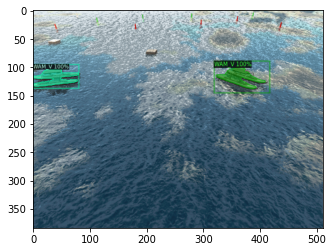

In [13]:
from detectron2.utils.visualizer import ColorMode
import random
import time

#print(dataset_dicts)
fn = '/home/arg/Mask-RCNN-Detectron2/datasets/test/36.main.jpg'
im = cv2.imread(fn)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#print(im)
t1 = time.time()
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
               metadata=subt_metadata, 
               scale=0.8)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1], cmap='nipy_spectral')
t2 = time.time()
print(t2 - t1)

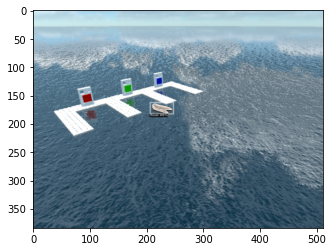

In [17]:
from detectron2.utils.visualizer import ColorMode
import random

for d in random.sample(dataset_dicts, 2):    
    im = cv2.imread(d["file_name"])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    #print(im)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=subt_metadata, 
                   scale=0.8
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1], cmap='nipy_spectral')